## Setup

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import colors
import numpy as np
import qutip as qt
from qutip.qip.operations import *
from qutip.qip.circuit import *
from qutip.qip.operations import s_gate
import sys
sys.path.append('../SimulationCode/')
from BlindGatesSimulation import *
from fiber_network import FiberNetwork
from SiVnodes import SiV
from SiVgates import *
from Plots import *
import pandas as pd
import matplotlib as mpl

In [2]:
# colors for plots
c1 = '#F15F57'
c2 = '#F6851F'
c3 = '#FDB913'
c4 = '#743062'
c5 = '#C87EB5'
c6 = '#4CC0B3'
c7 = '#1C9AAA'

## Define SiVs 

In [6]:
# Create SiVs, all numbers in MHz:

#Server A, G12
siv_a = SiV(kappa_in= (74.9 - 54.5)*(10**3), kappa_w= (54.5)*(10**3), g=5.6*(10**3), wCav = (0)*(10**3), 
             wSiv = -(479.8 -639.6)*(10**3), dwEl = 0.5*(10**3)) # G12
#Server B, B16
siv_b = SiV(kappa_in= (43.5 - 26.0)*(10**3), kappa_w= (26.0)*(10**3), g=8.5*(10**3), wCav = (0)*(10**3), 
             wSiv = -(804.9 -657.6)*(10**3), dwEl = -0.5*(10**3)) # B16

## Setup single Node experiments in B16

In [7]:
# Create Networks:
b16_network = FiberNetwork(siv_b) # this device is now in B16 fridge
# Create Simulation:
sim = BlindComputing(b16_network)

In [8]:
# Setup efficiencies

b16_network.fibercoupling_eff = 0.6
b16_network.tdi_eff = 0.35*0.3
b16_network.snspd_eff = 0.9
b16_network.detection_eff
b16_network.detection_eff_reset()
print('Detection efficientvy is = ', b16_network.detection_eff)

Detection efficientvy is =  0.0567


In [9]:
# Double check the contrast
contrast = siv_a.get_best_contrast()
print("Node A contrast = ", contrast)
contrast = siv_b.get_best_contrast()
print("Node B contrast = ", contrast)


Node A contrast =  161.2874309722681
Node B contrast =  71.9912989176812


In [11]:
b16_contrast = 25 # range 18 - 30
g12_contrast = 20 # range 12 - 20

siv_b.set_contrast(b16_contrast)
actual_contrast_b16 = siv_b.get_best_contrast()
print("B16 contrast is set to = ", actual_contrast_b16)

new contrast 27.979731852612378
B16 contrast is set to =  27.979731852612378


## Single gate fidelities and blindness as a function of MW errors

In [24]:
mw_list = np.linspace(1, 0.7, 6)
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

In [25]:
# redoing the structure to make calculations faster. Scan mw first, then phi then n rounds 
# do calculations on all of the matricies, don't save
# do errors properly

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': - 0.1, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [1, 1] # default fidelities
               }

cluster_state_length = 1

n_rounds = 10
n_col = 6
mu = 0.05

rates_apd1_apd2_angle = np.empty((0, 2), dtype=float)
rho_mw_phi_n_array_s = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)
rho_mw_phi_n_array_cl = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)

#phi list
for i in range(len(mw_list)) :
    imperfections['mw_fid_num']= [mw_list[i], mw_list[i]]
    print(mw_list[i])
    # my list
    rates_apd1_apd2 = np.empty((0, 2), dtype=float)
    rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
    rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)

    for j in range(len(phi1)):
        rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
        rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)
        phi1e = phi1[j]
        print("Phi angle = ", phi1e)
        for i in range(n_rounds): 
            rho_init_xp = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_n_array_s = np.append(rho_n_array_s, [rho_init_xp[0]], axis = 0)
            rho_n_array_cl = np.append(rho_n_array_cl, [(qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))], axis = 0)
        rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])
        
        rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
        rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])
    
    rho_mw_phi_n_array_s= np.vstack([rho_mw_phi_n_array_s, [rho_phi_n_array_s]])
    rho_mw_phi_n_array_cl= np.vstack([rho_mw_phi_n_array_cl, [rho_phi_n_array_cl]])


1.0
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
0.94
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
0.88
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
0.82
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
0.76
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
0.7
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345


#### Fidelity of the gates

In [26]:
## compare to ideal results

fid_err =  np.empty((0, 2), dtype=float)
fid_ave =  np.empty((0, 2), dtype=float)

for i in range(len(mw_list)):
    fid_err_phi_mw =  np.empty((0, 2), dtype=float)
    fid_ave_phi_mw =  np.empty((0, 2), dtype=float)
    for j in range(len(phi1)):
        U = rz(phi1[j])
        el_rho_final_ideal = U*el_initial_xp*U.dag()
        fid_mw =  np.empty((0, 2), dtype=float)
        for k in range(n_rounds):
            fid = (qt.fidelity(qt.Qobj(rho_mw_phi_n_array_cl[i][j][k]), el_rho_final_ideal))**2
            fid_mw = np.append(fid_mw, fid)
        fid_ave_mw = np.mean(fid_mw, axis = 0)
        # this is only the variability of the measurement
        fid_ave_std = np.std(fid_mw, axis = 0)/(np.sqrt(n_rounds))
        fid_ave_phi_mw = np.append(fid_ave_phi_mw, fid_ave_mw)
        fid_err_phi_mw = np.append(fid_err_phi_mw, fid_ave_std)
    
    fid_ave = np.append(fid_ave, fid_ave_phi_mw)
    fid_err = np.append(fid_err, fid_err_phi_mw)
    

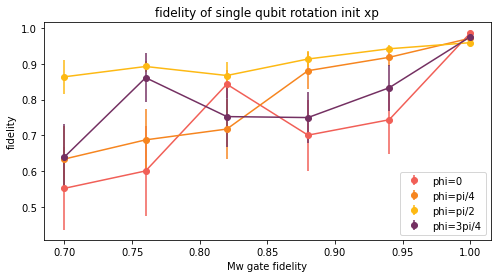

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(mw_list, fid_ave[::len(phi1)], color=c1)
plt.errorbar(mw_list,  fid_ave[::len(phi1)], yerr= fid_err[::len(phi1)],  fmt='o', color=c1, label='phi=0')
plt.plot(mw_list, fid_ave[1::len(phi1)], color=c2)
plt.errorbar(mw_list,  fid_ave[1::len(phi1)], yerr= fid_err[1::len(phi1)],  fmt='o', color=c2, label='phi=pi/4')
plt.plot(mw_list, fid_ave[2::len(phi1)], color=c3)
plt.errorbar(mw_list,  fid_ave[2::len(phi1)], yerr= fid_err[2::len(phi1)],  fmt='o', color=c3, label='phi=pi/2')
plt.plot(mw_list, fid_ave[3::len(phi1)], color=c4)
plt.errorbar(mw_list,  fid_ave[3::len(phi1)], yerr= fid_err[3::len(phi1)],  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('Mw gate fidelity')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init xp')
plt.legend()
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/PaperFigs/Fid_xpinit_mu0002_vs_mw.pdf', format='pdf')   # Save as PDF


# Show the plot
plt.show()

#### Checking mw fidelities when noise is incorporates

In [ ]:
fidel_values_pi_pi2 = {'pi': 0.86,
                'pi_half': 0.86
                }

pi_fid_arr_n =  np.empty((0, 2), dtype=float)
pi2_fid_arr_n =  np.empty((0, 2), dtype=float)
n_rounds_array = [5, 10]

for n_rounds in n_rounds_array:
    pi_fid_arr =  np.empty((0, 2), dtype=float)
    pi2_fid_arr =  np.empty((0, 2), dtype=float)
    for i in range(n_rounds):
        print(i)
        gates = set_mw_fidelities('real', 1, fidel_values_pi_pi2)
        pi_fid = qt.fidelity(gates['pi']*qt.basis(2,0), qt.basis(2,1))**2
        pi2_fid = qt.fidelity(gates['pi_half']*qt.basis(2,0), (qt.basis(2,0)+ qt.basis(2,1)).unit())**2
        pi_fid_arr = np.append(pi_fid_arr, pi_fid)
        pi2_fid_arr = np.append(pi2_fid_arr, pi2_fid)
    pi_fid_arr_n = np.append(pi_fid_arr_n, np.array([np.mean(pi_fid_arr), np.std(pi_fid_arr)/np.sqrt(n_rounds)]))
    pi2_fid_arr_n = np.append(pi2_fid_arr_n, np.array([np.mean(pi2_fid_arr), np.std(pi2_fid_arr)/np.sqrt(n_rounds)]))

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(n_rounds_array, pi_fid_arr_n[::2], color=c1)
plt.errorbar(n_rounds_array,  pi_fid_arr_n[::2], yerr= pi_fid_arr_n[1::2],  fmt='o', color=c1, label='phi=0')

plt.plot(n_rounds_array, pi2_fid_arr_n[::2], color=c4)
plt.errorbar(n_rounds_array,  pi2_fid_arr_n[::2], yerr= pi2_fid_arr_n[1::2],  fmt='o', color=c4, label='phi=0')

#Add labels and title
plt.xlabel('n_rounds')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init xp')
plt.legend()

# Show the plot
plt.show()

#### Blindness of the gates

In [30]:
## compare to ideal results

fid_err =  np.empty((0, 2), dtype=float)
fid_ave =  np.empty((0, 2), dtype=float)

for i in range(len(mw_list)):
    fid_err_phi_mw =  np.empty((0, 2), dtype=float)
    fid_ave_phi_mw =  np.empty((0, 2), dtype=float)
    for j in range(len(phi1)):
        U = rz(phi1[j])
        el_rho_final_ideal = U*el_initial_xp*U.dag()
        fid_mw =  np.empty((0, 2), dtype=float)
        for k in range(n_rounds):
            fid = (qt.fidelity(qt.Qobj(rho_mw_phi_n_array_cl[i][j][k]), el_rho_final_ideal))**2
            fid_mw = np.append(fid_mw, fid)
        fid_ave_mw = np.mean(fid_mw, axis = 0)
        # this is only the variability of the measurement
        fid_ave_std = np.std(fid_mw, axis = 0)/(np.sqrt(n_rounds))
        fid_ave_phi_mw = np.append(fid_ave_phi_mw, fid_ave_mw)
        fid_err_phi_mw = np.append(fid_err_phi_mw, fid_ave_std)
    
    fid_ave = np.append(fid_ave, fid_ave_phi_mw)
    fid_err = np.append(fid_err, fid_err_phi_mw)
    

In [35]:
hol_err =  np.empty((0, 2), dtype=float)
hol_ave =  np.empty((0, 2), dtype=float)

for i in range(len(mw_list)):
    print(i)
    rho_ave_phi_array =  np.empty((0, 2, 2), dtype=float)
    eigen_phi_std_array = np.empty((0, 2), dtype=float)
    eig_eta_array = np.empty((0, 2), dtype=float)
    for j in range(len(phi1)):
        nxnynz_array =  np.empty((0, 3), dtype=float)
        for k in range(n_rounds):
            nx, ny, nz = np.round(calculate_bloch_components(qt.Qobj(rho_mw_phi_n_array_s[i][j][k])), 5)
            nxnynz_array =  np.vstack([nxnynz_array, [nx, ny, nz]])
        mean_nxnynz = np.mean(nxnynz_array, axis =0)
        std_nxnynz = np.std(nxnynz_array, axis =0)/np.sqrt(n_rounds)
        std_eigen_eta = eigenvalue_uncertainty(mean_nxnynz, std_nxnynz)
        eigen_eta = [(1/2)*(1 -np.sqrt(np.sum(mean_nxnynz**2))), (1/2)*(1 +np.sqrt(np.sum(mean_nxnynz**2)))]
        print(eigen_eta, std_eigen_eta)

        eig_eta_array = np.append(eig_eta_array, np.array([eigen_eta]))
        # density state for a phi
        rho_ave_phi = np.mean(rho_mw_phi_n_array_s[i][j], axis = 0)
        rho_ave_phi_array = np.append(rho_ave_phi_array, [rho_ave_phi], axis = 0)
        eigen_phi_std_array = np.append(eigen_phi_std_array, std_eigen_eta)

    rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)
    nxnynz = np.array([calculate_bloch_components(qt.Qobj(rho_ave_tot))])
    nxnynz_std = np.sqrt(np.sum(eigen_phi_std_array**2))/len(eigen_phi_std_array)

    # std of variability of eigenvalues of rho tot
    std_eigen_eta = eigenvalue_uncertainty(nxnynz.ravel(), [nxnynz_std,nxnynz_std,nxnynz_std])
    eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())

    hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])
    rho_tot_sigma_lambdas = (std_eigen_eta, std_eigen_eta)
    rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
    rho_lambdas = [(eig_eta_array[i], eig_eta_array[i+1]) for i in range(0, len(eig_eta_array), 2)] 
    rho_sigma_lambdas =  [(value, value) for value in eigen_phi_std_array]
    hv_std = holevo_bound_uncertainty_1q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)
    hol_ave = np.append(hol_ave, hv_tot)
    hol_err = np.append(hol_err, hv_std)


0
[0.298952735281601, 0.701047264718399] 0.13999968595811615
[0.3819105460625294, 0.6180894539374706] 0.1052963097435874
[0.24559056814211866, 0.7544094318578813] 0.10207355433445268
[0.18289504826635072, 0.8171049517336493] 0.07636588472572065
1
[0.3260678020448773, 0.6739321979551227] 0.10893514389115375
[0.39635248533008616, 0.6036475146699138] 0.09404608791450636
[0.26979755876457345, 0.7302024412354265] 0.11077274894584926
[0.30534423109242304, 0.694655768907577] 0.07949270055626104
2
[0.4059583304220943, 0.5940416695779057] 0.09937538417584052
[0.21537191860034255, 0.7846280813996575] 0.0685452341101627
[0.43976910083271215, 0.5602308991672879] 0.12241738264657277
[0.3242187427127113, 0.6757812572872888] 0.08250769907105313
3
[0.3666470809046536, 0.6333529190953464] 0.10133508624459803
[0.325466023281282, 0.674533976718718] 0.07975736167321534
[0.24793609878247147, 0.7520639012175285] 0.09359764244352718
[0.35781467901801534, 0.6421853209819847] 0.08710035051143546
4
[0.323511780

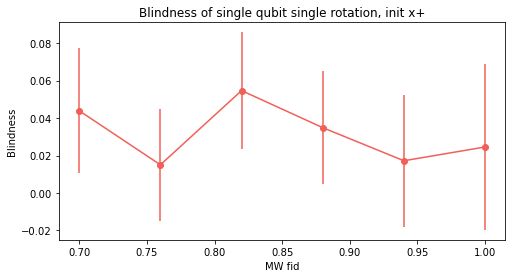

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(mw_list, hol_ave, color=c1)
plt.errorbar(mw_list,  hol_ave, yerr= hol_err,  fmt='o', color=c1)

#Add labels and title
plt.xlabel('MW fid')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init x+')
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/PaperFigs/Blind_xpinit_mu0002_vs_mw.pdf', format='pdf')   # Save as PDF


# Show the plot
plt.show()

In [39]:
def blindness_singleRot(rho_array_cl):
        """
        Calculate the Holevo bound and its uncertainty given an array of density matrices and their standard deviations.
        
        Parameters:
        - rho_phi_array: List or array of density matrices corresponding to different phases.
        - rho_std_phi_array: List or array of standard deviations for each element in the density matrices.
        - delta: Small perturbation value for numerical derivative (default is 1e-6).
        
        Returns:
        - holevo: The calculated Holevo bound.
        - holevo_error: The uncertainty in the Holevo bound.
        """
        
        # Calculate the average density matrix
        rho_all = np.mean(rho_phi_array, axis=0)
        
        # Calculate the mean entropy of the individual density matrices
        mn = np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_phi_array])

        # Calculate the Holevo bound
        holevo = qt.entropy_vn(qt.Qobj(rho_all)) - mn

        # Initialize the error in the Holevo bound
        holevo_error = 0
        
        for k, rho in enumerate(rho_phi_array):
            partial_derivatives = np.zeros(rho.shape, dtype=complex)
            chi = holevo
            
            # Calculate the partial derivatives numerically
            for i in range(rho.shape[0]):
                for j in range(rho.shape[1]):
                    perturbed_rho = rho.copy()
                    
                    # Apply perturbation and ensure Hermiticity
                    delta_rho = np.zeros(rho.shape, dtype=complex)
                    delta_rho[i, j] = delta
                    delta_rho[j, i] = np.conj(delta_rho[i, j])  # Ensure Hermiticity
                    
                    # Adjust diagonal elements to preserve trace
                    trace_adjustment = np.trace(delta_rho)
                    delta_rho[i, i] -= trace_adjustment / rho.shape[0]
                    
                    perturbed_rho += delta_rho
                    
                    # Calculate perturbed average density matrix
                    perturbed_rho_all = np.mean(
                        [perturbed_rho if idx == k else rho_phi_array[idx] for idx in range(len(rho_phi_array))],
                        axis=0
                    )
                    
                    # Recalculate mean entropy
                    perturbed_mn = np.mean([qt.entropy_vn(qt.Qobj(rho_phi)) for rho_phi in rho_phi_array])
                    
                    # Calculate perturbed Holevo bound
                    perturbed_chi = qt.entropy_vn(qt.Qobj(perturbed_rho_all)) - perturbed_mn
                    
                    # Calculate the partial derivative
                    partial_derivatives[i, j] = (perturbed_chi - chi) / delta
            
            # Sum the squared errors propagated through each partial derivative
            holevo_error += np.sum((np.abs(partial_derivatives) * rho_std_phi_array[k]) ** 2)
        
        # Take the square root to obtain the final uncertainty
        holevo_error = np.abs(np.sqrt(holevo_error))
        return holevo, holevo_error

## Single gate fidelities and blindness as a function of contrast errors

In [46]:
contrast_list = np.array([ 7., 12.])
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

In [49]:
# redoing the structure to make calculations faster. Scan mw first, then phi then n rounds 
# do calculations on all of the matricies, don't save
# do errors properly

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': - 0.1, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [1, 1] # default fidelities
               }
cluster_state_length = 1

n_rounds = 10
n_col = 6
mu = 0.05

rates_apd1_apd2_angle = np.empty((0, 2), dtype=float)
rho_contr_phi_n_array_s = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)
rho_contr_phi_n_array_cl = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)

#phi list
for i in range(len(contrast_list)):
    contrast = contrast_list[i]

    print(contrast)
    real_contrasts = np.empty((0, 2), dtype=float)

    # move SiV in B16 to a new contrast location
    siv_b.set_contrast(contrast)
    actual_contrast = siv_b.get_best_contrast()
    real_contrasts = np.append(real_contrasts, actual_contrast)

    rates_apd1_apd2 = np.empty((0, 2), dtype=float)
    rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
    rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)

    for j in range(len(phi1)):
        rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
        rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)
        phi1e = phi1[j]
        print("Phi angle = ", phi1e)
        for i in range(n_rounds): 
            rho_init_xp = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_n_array_s = np.append(rho_n_array_s, [rho_init_xp[0]], axis = 0)
            rho_n_array_cl = np.append(rho_n_array_cl, [(qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))], axis = 0)
        rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])
        
        rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
        rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])
    
    rho_contr_phi_n_array_s= np.vstack([rho_contr_phi_n_array_s, [rho_phi_n_array_s]])
    rho_contr_phi_n_array_cl= np.vstack([rho_contr_phi_n_array_cl, [rho_phi_n_array_cl]])



7.0
new contrast 9.981021888931672
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
12.0
new contrast 9.981021888931672
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345


#### Fidelity of the gates

In [50]:
## compare to ideal results

fid_err =  np.empty((0, 2), dtype=float)
fid_ave =  np.empty((0, 2), dtype=float)

for i in range(len(contrast_list)):
    fid_err_phi_contr =  np.empty((0, 2), dtype=float)
    fid_ave_phi_contr =  np.empty((0, 2), dtype=float)
    for j in range(len(phi1)):
        U = rz(phi1[j])
        el_rho_final_ideal = U*el_initial_xp*U.dag()
        fid_contr =  np.empty((0, 2), dtype=float)
        for k in range(n_rounds):
            fid = (qt.fidelity(qt.Qobj(rho_contr_phi_n_array_cl[i][j][k]), el_rho_final_ideal))**2
            fid_contr = np.append(fid_contr, fid)
        fid_ave_contr = np.mean(fid_contr, axis = 0)
        # this is only the variability of the measurement
        fid_ave_std = np.std(fid_contr, axis = 0)/(np.sqrt(n_rounds))
        fid_err_phi_contr = np.append(fid_err_phi_contr, fid_ave_std)
    
    fid_ave = np.append(fid_ave, fid_ave_phi_contr)
    fid_err = np.append(fid_err, fid_err_phi_contr)
    

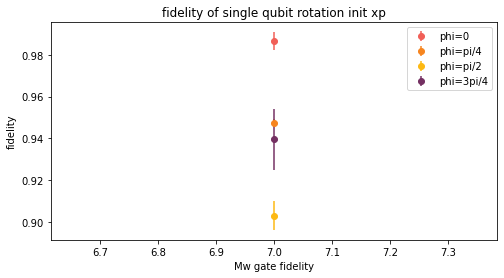

In [51]:

plt.figure(figsize=(8, 4))
plt.plot(contrast_list[:-1], fid_ave[::len(phi1)][:-1], color=c1)
plt.errorbar(contrast_list[:-1],  fid_ave[::len(phi1)][:-1], yerr= fid_err[::len(phi1)][:-1],  fmt='o', color=c1, label='phi=0')
plt.plot(contrast_list[:-1], fid_ave[1::len(phi1)][:-1], color=c2)
plt.errorbar(contrast_list[:-1],  fid_ave[1::len(phi1)][:-1], yerr= fid_err[1::len(phi1)][:-1],  fmt='o', color=c2, label='phi=pi/4')
plt.plot(contrast_list[:-1], fid_ave[2::len(phi1)][:-1], color=c3)
plt.errorbar(contrast_list[:-1],  fid_ave[2::len(phi1)][:-1], yerr= fid_err[2::len(phi1)][:-1],  fmt='o', color=c3, label='phi=pi/2')
plt.plot(contrast_list[:-1], fid_ave[3::len(phi1)][:-1], color=c4)
plt.errorbar(contrast_list[:-1],  fid_ave[3::len(phi1)][:-1], yerr= fid_err[3::len(phi1)][:-1],  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('Mw gate fidelity')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init xp')
plt.legend()
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/PaperFigs/Fid_xpinit_mu0002_vs_mw.pdf', format='pdf')   # Save as PDF


# Show the plot
plt.show()

#### Blindness of the gates

In [53]:
hol_err =  np.empty((0, 2), dtype=float)
hol_ave =  np.empty((0, 2), dtype=float)

for i in range(len(contrast_list)):
    print(i)
    rho_ave_phi_array =  np.empty((0, 2, 2), dtype=float)
    eigen_phi_std_array = np.empty((0, 2), dtype=float)
    eig_eta_array = np.empty((0, 2), dtype=float)
    for j in range(len(phi1)):
        nxnynz_array =  np.empty((0, 3), dtype=float)
        for k in range(n_rounds):
            nx, ny, nz = calculate_bloch_components(qt.Qobj(rho_contr_phi_n_array_cl[i][j][k]))
            nxnynz_array =  np.vstack([nxnynz_array, [nx, ny, nz]])
        mean_nxnynz = np.mean(nxnynz_array, axis =0)
        std_nxnynz = np.std(nxnynz_array, axis =0)/np.sqrt(n_rounds)
        std_eigen_eta = eigenvalue_uncertainty(mean_nxnynz, std_nxnynz)
        eigen_eta = [(1/2)*(1 -np.sqrt(np.sum(mean_nxnynz**2))), (1/2)*(1 +np.sqrt(np.sum(mean_nxnynz**2)))]
        # print(eigen_eta, std_eigen_eta)

        eig_eta_array = np.append(eig_eta_array, np.array([eigen_eta]))
        # density state for a phi
        rho_ave_phi = np.mean(rho_contr_phi_n_array_s[i][j], axis = 0)
        rho_ave_phi_array = np.append(rho_ave_phi_array, [rho_ave_phi], axis = 0)
        eigen_phi_std_array = np.append(eigen_phi_std_array, std_eigen_eta)

    rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)
    nxnynz = np.array([calculate_bloch_components(qt.Qobj(rho_ave_tot))])
    nxnynz_std = np.sqrt(np.sum(eigen_phi_std_array**2))/len(eigen_phi_std_array)

    # std of variability of eigenvalues of rho tot
    std_eigen_eta = eigenvalue_uncertainty(nxnynz.ravel(), [nxnynz_std,nxnynz_std,nxnynz_std])
    eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())

    hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])
    rho_tot_sigma_lambdas = (std_eigen_eta, std_eigen_eta)
    rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
    rho_lambdas = [(eig_eta_array[i], eig_eta_array[i+1]) for i in range(0, len(eig_eta_array), 2)] 
    rho_sigma_lambdas =  [(value, value) for value in eigen_phi_std_array]
    print(rho_tot_lambdas)
    print(rho_tot_sigma_lambdas)
    print(rho_lambdas)
    print(rho_sigma_lambdas)

    hv_std = holevo_bound_uncertainty_1q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)
    hol_ave = np.append(hol_ave, hv_tot)
    hol_err = np.append(hol_err, hv_std)


0
(0.19923893570384, 0.80076106429616)
(0.007599210177062265, 0.007599210177062265)
[(0.011910840610884488, 0.9880891593891155), (0.03639949337378273, 0.9636005066262172), (0.0962584552928678, 0.9037415447071322), (0.06033025003009296, 0.939669749969907)]
[(0.004224512461996314, 0.004224512461996314), (0.03595066031754395, 0.03595066031754395), (0.008391781826283687, 0.008391781826283687), (0.048116039063307504, 0.048116039063307504)]
1
(0.21210355895591182, 0.7878964410440882)
(0.00830869513281823, 0.00830869513281823)
[(0.011910840610884488, 0.9880891593891155), (0.046673518592725394, 0.9533264814072746), (0.09590244791941516, 0.9040975520805848), (0.06033025003009285, 0.9396697499699072)]
[(0.004224512461996314, 0.004224512461996314), (0.04096019814357704, 0.04096019814357704), (0.02018576219029448, 0.02018576219029448), (0.048116039063307504, 0.048116039063307504)]


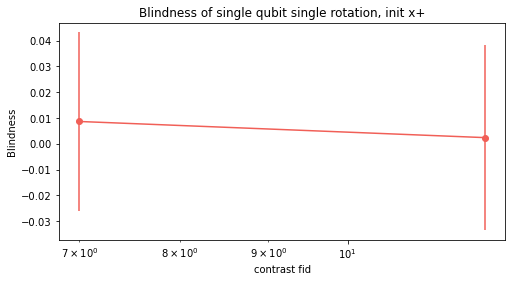

In [54]:
plt.figure(figsize=(8, 4))
plt.plot(contrast_list, hol_ave, color=c1)
plt.errorbar(contrast_list,  hol_ave, yerr= hol_err,  fmt='o', color=c1)

#Add labels and title
plt.xlabel('contrast fid')
plt.xscale('log')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init x+')
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/PaperFigs/Blind_xpinit_mu0002_vs_contrast.pdf', format='pdf')   # Save as PDF


# Show the plot
plt.show()

## Single gate fidelities and blindness as a function of mu errors

In [62]:
mu_list = np.linspace(0.0001, 0.5, 6)

phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

In [63]:
b16_contrast = 25 # range 18 - 30
g12_contrast = 20 # range 12 - 20

siv_b.set_contrast(b16_contrast)
actual_contrast_b16 = siv_b.get_best_contrast()
print("B16 contrast is set to = ", actual_contrast_b16)

new contrast 22.03805164132863
B16 contrast is set to =  22.03805164132863


In [64]:
# redoing the structure to make calculations faster. Scan mw first, then phi then n rounds 
# do calculations on all of the matricies, don't save
# do errors properly

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': - 0.1, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [1, 1] # default fidelities
               }
cluster_state_length = 1

n_rounds = 10
n_col = 6

rates_apd1_apd2_angle = np.empty((0, 2), dtype=float)
rho_mu_phi_n_array_s = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)
rho_mu_phi_n_array_cl = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)

#phi list
for i in range(len(mu_list)):
    mu = mu_list[i]

    print(mu)

    rates_apd1_apd2 = np.empty((0, 2), dtype=float)
    rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
    rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)

    for j in range(len(phi1)):
        rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
        rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)
        phi1e = phi1[j]
        print("Phi angle = ", phi1e)
        for i in range(n_rounds): 
            rho_init_xp = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_n_array_s = np.append(rho_n_array_s, [rho_init_xp[0]], axis = 0)
            rho_n_array_cl = np.append(rho_n_array_cl, [(qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))], axis = 0)
        rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])
        
        rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
        rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])
    
    rho_mu_phi_n_array_s= np.vstack([rho_mu_phi_n_array_s, [rho_phi_n_array_s]])
    rho_mu_phi_n_array_cl= np.vstack([rho_mu_phi_n_array_cl, [rho_phi_n_array_cl]])



0.0001
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
0.10008
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
0.20006
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
0.30004
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
0.40002
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
0.5
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345


#### Fidelity of the gates

In [65]:
## compare to ideal results

fid_err =  np.empty((0, 2), dtype=float)
fid_ave =  np.empty((0, 2), dtype=float)

for i in range(len(mu_list)):
    fid_err_phi_mu =  np.empty((0, 2), dtype=float)
    fid_ave_phi_mu =  np.empty((0, 2), dtype=float)
    for j in range(len(phi1)):
        U = rz(phi1[j])
        el_rho_final_ideal = U*el_initial_xp*U.dag()
        fid_mu =  np.empty((0, 2), dtype=float)
        for k in range(n_rounds):
            fid = (qt.fidelity(qt.Qobj(rho_mu_phi_n_array_cl[i][j][k]), el_rho_final_ideal))**2
            fid_mu = np.append(fid_mu, fid)
        fid_ave_mu = np.mean(fid_mu, axis = 0)
        # this is only the variability of the measurement
        fid_ave_std = np.std(fid_contr, axis = 0)/(np.sqrt(n_rounds))
        fid_err_phi_mu = np.append(fid_err_phi_mu, fid_ave_std)
    
    fid_ave = np.append(fid_ave, fid_ave_phi_mu)
    fid_err = np.append(fid_err, fid_err_phi_mu)
    

NameError: name 'rho_mu_phi_n_array_cl' is not defined

## Single gate fidelities and blindness as a function of TDI errors

In [ ]:
tdi_list = np.linspace(-1, 1, 6)

phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

In [ ]:
# redoing the structure to make calculations faster. Scan mw first, then phi then n rounds 
# do calculations on all of the matricies, don't save
# do errors properly

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': - 0.1, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [1, 1] # default fidelities
               }
cluster_state_length = 1
mu = 0.01
n_rounds = 10
n_col = 6

rates_apd1_apd2_angle = np.empty((0, 2), dtype=float)
rho_contr_phi_n_array_s = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)
rho_contr_phi_n_array_cl = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)

#phi list
for i in range(len(mu_list)):
    mu = tdi_list[i]

    print(mu)

    rates_apd1_apd2 = np.empty((0, 2), dtype=float)
    rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
    rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)

    for j in range(len(phi1)):
        rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
        rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)
        phi1e = phi1[j]
        print("Phi angle = ", phi1e)
        for i in range(n_rounds): 
            rho_init_xp = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_n_array_s = np.append(rho_n_array_s, [rho_init_xp[0]], axis = 0)
            rho_n_array_cl = np.append(rho_n_array_cl, [(qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))], axis = 0)
        rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])
        
        rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
        rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])
    
    rho_contr_phi_n_array_s= np.vstack([rho_contr_phi_n_array_s, [rho_phi_n_array_s]])
    rho_contr_phi_n_array_cl= np.vstack([rho_contr_phi_n_array_cl, [rho_phi_n_array_cl]])

